# Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B
На сайте запущен А/В тест с целью увеличить доход  В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenu. 
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

*__Подготовка данных.__*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [2]:
data = pd.read_excel('AB_Test_Results (2).xlsx')

data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [5]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [6]:
data.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

__*Посмотрим на группы отдельно*__

In [7]:
data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


In [8]:
data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в control группе сильно больше, чем в группе variant. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

__*Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.*__

In [9]:
v = data.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [10]:
more_than_one_types = v.query('VARIANT_NAME > 1')
data_new = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')
data_new.shape

(6070, 3)

In [11]:
data_new.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    3044
control    3026
Name: count, dtype: int64

Уже видно, что почти 4 тысячи юзеров попали в обе группы. Это вызывает вопросы к сплитовалке и к результатам самого теста в целом.

__*Проверка на нормальность распределения и применение статистических критериев*__

Так как выборки менее 5 тысяч, применим для проверки на нормальность тест Шапиро-Уилка

In [12]:
from scipy.stats import shapiro

alpha = 0.05
st = shapiro(data_new.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));


Distribution is not normal



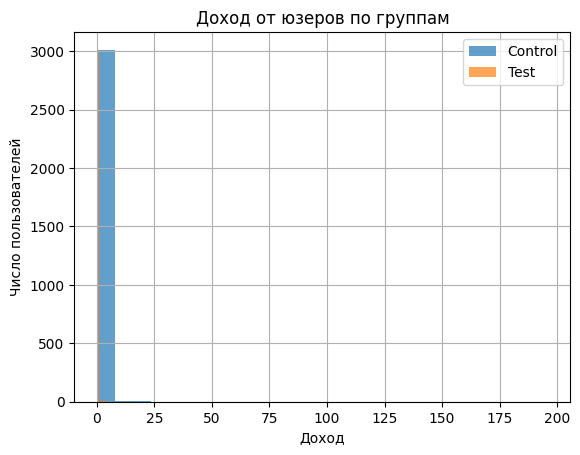

In [13]:
data_new['REVENUE'][data_new['VARIANT_NAME'] == 'control'].hist(bins = 25, alpha =0.7, label='Control')
data_new['REVENUE'][data_new['VARIANT_NAME'] == 'variant'].hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход от юзеров по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

И тест и гистограмма показывают, что распределение не нормально.

<img src="https://lit-review.ru/wp-content/uploads/2018/04/vibor_stat_kriteria-1024x774.png"/>

Следуя таблице для дальнйшей оценки теста применим критерий Манна-Уитни

In [14]:
data_new.groupby('VARIANT_NAME')['REVENUE'].describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,3026.0,0.155506,3.708620,0.0,0.0,0.0,0.0,196.01
variant,3044.0,0.058909,0.760344,0.0,0.0,0.0,0.0,23.04


In [15]:
from scipy.stats import mannwhitneyu

mw_stats = mannwhitneyu(x=data_new[(data_new['VARIANT_NAME'] == 'control')]['REVENUE'].values,
                                                  y=data_new[(data_new['VARIANT_NAME'] == 'variant')]['REVENUE'].values)
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

### Итог

__pvalue > 0.05__  
__*Статистически значимой разницы между выборками не обнаружено. Остаёмся на контрольной/начальной версии продукта.*__
